In [157]:
import platform

print(platform.machine())

arm64


In [215]:
import io
import os
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import pathlib

import time
from selenium import webdriver
from PIL import Image
from matplotlib import pyplot as plt

In [229]:
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
device = torch.device("cpu")

class ImageDataset(Dataset):
    def __init__(self, labels, data, transform=None, target_transform=None):
        self.img_labels = torch.from_numpy(labels)
        self.img_labels = self.img_labels.to(device)
        
        data = np.moveaxis(data, 3, 1)
        self.img_data = torch.from_numpy(data)
        self.img_data = self.img_data.to(device)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        #return len(self.img_labels)
        return len(self.img_labels)*50

    def __getitem__(self, idx):
        idx = idx % len(self.img_labels)
        image = self.img_data[idx]
        
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

(112, 112, 3)
tensor(0)
tensor(0.3133)


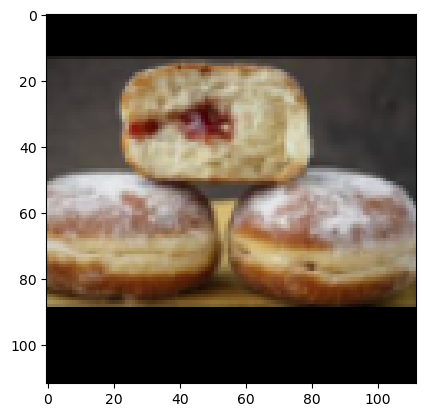

In [257]:
import torch.nn as nn

X_train = list()
y_train = list()

for file in pathlib.Path("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/pfannkuchen").iterdir():
    if file.is_file() and file.suffix == ".bmp":
        pic = Image.open("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/pfannkuchen/" + file.name)
        pix = np.asarray(pic)
        pix = pix / 255.0
        pix = pix.astype(np.float32)
        
        X_train.append(pix)
        y_train.append(1)
        
length = len(X_train)

for file in pathlib.Path("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/berliner").iterdir():
    if file.is_file() and file.suffix == ".bmp":
        pic = Image.open("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/berliner/" + file.name)
        pix = np.asarray(pic)
        pix = pix / 255.0
        pix = pix.astype(np.float32)
        
        
        X_train.append(pix)
        y_train.append(0)
        if len(X_train) >= length*2:
            break

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = X_train[0:65]
y_test = y_train[0:65]

X_test = np.concatenate([X_test, X_train[len(X_train)-65:len(X_train)]])
y_test = np.concatenate([y_test, y_train[len(y_train)-65:len(y_train)]])
X_train = X_train[65:len(X_train)-65]
y_train = y_train[65:len(y_train)-65]

trainset = ImageDataset(y_train, X_train, transform=transforms.Compose([
    #transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
    #transforms.RandomRotation(degrees=(-45, 45)),
    transforms.RandomResizedCrop(112, scale=(0.7,1.0), ratio=(0.7,1.33))
]))


data, lbl = trainset.__getitem__(400)
data = np.asarray(data)
data = np.moveaxis(data, 0, 2)

loss = nn.CrossEntropyLoss()

print(data.shape)
print(lbl)
vals = torch.tensor([float(0), float(0)])
vals[lbl] = float(1)
print(loss(torch.tensor([float(1.0), float(0.0)]), lbl))
plt.imshow(data) 
plt.show()


In [272]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, padding=2) 
        self.pool1 = nn.MaxPool2d(2, 2) # 56
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2) # 28
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2) # 14
        self.fc1 = nn.Linear(32 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(14*14*128, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x
    """
net = ConvNet()
net.to(device=device);

In [274]:
from tqdm import tqdm
import torch.optim as optim

# Fix random seed to get reproducibility
torch.manual_seed(42)

batch_size=25
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
losses = []
running_loss = []
for epoch in range(20):  # loop over the dataset multiple times

    # EXTRA: get a nice progress bar visualization
    train_progress  = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}", mininterval=0.3)
    for i, data in enumerate(train_progress, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        
        # print statistics
        running_loss.append(loss.item())
        losses.append(loss.item())
        train_progress.set_description(f"Epoch: {epoch+1}, loss: {loss.item():.3}")
    
    print(f"------ Epoch {epoch+1} ------")
    print(f"Loss: {sum(running_loss)/(len(running_loss))}")
    running_loss = []

print('Finished Training')
plt.plot(losses, label='train loss')
plt.legend()



Epoch 1:   0%|          | 0/1040 [00:00<?, ?it/s]/Users/robert/opt/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch: 1, loss: 0.44: 100%|██████████| 1040/1040 [01:07<00:00, 15.32it/s] 


------ Epoch 1 ------
Loss: 0.5201442571213613


Epoch: 2, loss: 0.322: 100%|██████████| 1040/1040 [01:06<00:00, 15.55it/s]


------ Epoch 2 ------
Loss: 0.3660682572481724


Epoch: 3, loss: 0.322: 100%|██████████| 1040/1040 [01:07<00:00, 15.41it/s]


------ Epoch 3 ------
Loss: 0.338666671829728


Epoch: 4, loss: 0.338: 100%|██████████| 1040/1040 [01:06<00:00, 15.69it/s]


------ Epoch 4 ------
Loss: 0.33537279416162236


Epoch: 5, loss: 0.353: 100%|██████████| 1040/1040 [01:06<00:00, 15.72it/s]


------ Epoch 5 ------
Loss: 0.32787976726316487


Epoch: 6, loss: 0.313:  73%|███████▎  | 756/1040 [00:48<00:18, 15.75it/s]


KeyboardInterrupt: 

In [ ]:
test_path = "/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/8e670e4afba12afb3a87c4b11598e6e11d1380a7.bmp"
test_pic = Image.open(test_path)
test_data = np.asarray(test_pic)
test_data = (test_data / 255.0)
test_data = test_data.astype(np.float32)
test_data = test_data.reshape(-1, 3 , 224, 224)
test_data = torch.from_numpy(test_data)

prediction = net(test_data)
prediction_loss = criterion(prediction, torch.tensor([0]))
prediction_loss
prediction

In [87]:
from sklearn import datasets
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from torchvision.transforms import RandomResizedCrop

"""
trainset = ImageDataset(y_train, X_train, transform=transforms.Compose([
    #RandomResizedCrop(112, scale=(0.7,1.0), ratio=(0.5,2))
]))
ml_dataloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=0)

impr_trainset_data = []
impr_trainset_labels = []
for batch in ml_dataloader:
    data, lbl = batch
    lbl = np.asarray(lbl)[0]
    data = np.asarray(data)
    data = np.moveaxis(data, 0, 2)
    impr_trainset_data.append(data)
    impr_trainset_labels.append(lbl)

impr_trainset_labels = np.asarray(impr_trainset_labels)    
impr_trainset_data = np.asarray(impr_trainset_data)
impr_trainset_data = impr_trainset_data.reshape(-1, 3 * 112 * 112)
""";
impr_trainset_data = X_train.reshape(-1, 3 * 112 * 112)
impr_trainset_labels = y_train

model = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear', verbose=1)
model.fit(impr_trainset_data, impr_trainset_labels)

(520, 112, 112, 3)
[LibLinear]iter  1 act 2.801e+02 pre 2.460e+02 delta 1.979e+00 f 3.604e+02 |g| 9.867e+02 CG  21
iter  2 act 4.864e+01 pre 3.940e+01 delta 1.979e+00 f 8.031e+01 |g| 2.509e+02 CG  20
iter  3 act 1.326e+01 pre 1.072e+01 delta 1.979e+00 f 3.167e+01 |g| 9.121e+01 CG  18
iter  4 act 3.579e+00 pre 2.961e+00 delta 1.979e+00 f 1.841e+01 |g| 3.255e+01 CG  18
iter  5 act 7.394e-01 pre 6.256e-01 delta 1.979e+00 f 1.483e+01 |g| 1.136e+01 CG  18
iter  6 act 1.692e-01 pre 1.492e-01 delta 1.979e+00 f 1.410e+01 |g| 3.723e+00 CG  24
iter  7 act 1.630e-02 pre 1.520e-02 delta 1.979e+00 f 1.393e+01 |g| 1.203e+00 CG  24
iter  8 act 5.257e-04 pre 5.232e-04 delta 1.979e+00 f 1.391e+01 |g| 2.022e-01 CG  25


LogisticRegression(multi_class='ovr', solver='liblinear', verbose=1)

In [ ]:
test_path = "/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/ccd1103058108dca8975f3aa0e15024118d43058.bmp"
test_path = "/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/5d218a52d5657d1b40909b8805944b3f83b29c8d.bmp"
test_pic = Image.open(test_path)
test_data = np.asarray(test_pic)
test_data = (test_data / 255.0)
test_data = test_data.astype(np.float32)
test_data = test_data.reshape(-1, 3 , 112, 112)
test_data = torch.from_numpy(test_data)
test_data = test_data.reshape(-1, 3 * 112 * 112)

pred = model.predict(test_data)
pred

print(f'Actual value from test data is 0 and corresponding image is as below')
plt.matshow(test_data.reshape((112,112,3))) 
plt.show()
print(f'Predicted value from test data is {pred[0]} and corresponding image is as below')



In [88]:
accs = []
for i in range(0,len(X_test)):
    data = X_test[i]
    data = data.reshape(-1, 112*112*3)
    label = y_test[i]
    pred = model.predict(data)
    
    accs.append(1 - np.abs(label - pred))
    #print(pred)
    #plt.matshow(data.reshape((112,112,3))) 
    #plt.show()
    
    
accuracy = sum(accs)*(1/len(accs))

In [89]:
print(accuracy)

[0.66923077]
